# PyTranscribe

## Objetivo
El objetivo de la aplicación será obtener a partir de un archivo en formato wav una transcripción musical. Se partirá de una serie de premisas (o limitaciones):
+ Únicamente se realizarán transcripciones musicales de instrumentos monofónicos.
+ Como entrada al programa se deberá especificar el tempo (beats-por-minuto) utilizado.
+ Se podrán transcribir una serie de figuras rítmicas básicas (redondas, blancas, negras y corcheas).
+ El archivo de audio debe comenzar exactamente en el primer pulso de la melodía.
+ Se supone que en la melodía no existen subarmónicos. Los subarmónicos pueden ser generados utilizando técnicas especiales en unos pocos instrumentos musicales, por lo que son poco comunes. También se pueden crear artificialmente.

## Planteamiento
Para conseguir esto, se deben hacer una serie de transformadas rápidas de Fourier (FFT) en el conjunto de muestras correspondiente a cada figura rítmica básica de la melodía. Para ello, debemos obtener un vector de muestras de todo el archivo wav, para posteriormente partir ese conjunto en subconjuntos con las muestras asociadas a cada corchea de la melodía.

Posteriormente, se llevará a cabo un análisis del espectro frecuencial de cada subconjunto de muestras, para determinar la frecuencia fundamental (si no se detecta ninguna nota se identifica un silencio). Esa frecuencia no coincidirá generalmente con la frecuencia asociada a una nota en particular, por lo que se debe aproximar a la nota más cercana, teniendo en cuenta que la relación frecuencial entre las notas de la escala temperada no es lineal.

Por último, se imprimen los resultados de las notas identificadas, teniendo en cuenta que si en dos figuras rítmicas mínimas adyacentes se ha detectado la misma nota, se deben juntar esas dos notas para conformar una figura rítmica de un valor superior.

## FFT de una señal de audio
Lo primero será llevar a cabo un estudio de cómo es la respuesta frecuencial para una sola nota y diferentes instrumentos. La frecuencia de muestreo debe cumplir el teorema de Nyquist para evitar aliasing en frecuencia.

La FFT es aplicable a un conjunto de datos de longitud potencia de 2, por lo que los subconjuntos asociados a cada figura rítmica básica deben restringirse a esos tamaños. El espectro en frecuencias generado por la FFT será el asociado a la repetición periódica de las muestras de entrada, y en general el fragmento de audio sobre el cual aplicamos el algoritmo no será periódico. Esto provoca la aparición de componentes de alta frecuencia que no pertenecían a la señal original. Este efecto indeseado se puede reducir gracias a la utilización de una ventana distinta a la ventana rectangular.

Se comenzará analizando una nota C5 tocada con clarinete. La frecuencia asociada a esta nota en afinación estándar a 440 Hz es de 523.3 Hz. Lo primero será crear una función para obtener las muestras de la señal a partir del archivo .wav **mono** grabado a la frecuencia de muestreo estándar de 44100 Hz.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import wave

def getSamples(file_name):
    # Se abre el archivo de audio
    audio = wave.open("audios/"+file_name, "r")

    # Obtenemos los datos del audio, y lo convertimos a un array de numpy
    # de enteros de 16 bits
    frames = audio.readframes(-1)
    signal = np.frombuffer(frames, dtype="int16")

    # Obtenemos los parámetros del audio
    fs = audio.getframerate()
    time = np.linspace(0, len(signal)/fs, num=len(signal))

    # Cerramos el archivo de audio
    audio.close()
    
    return [time, signal]

Se representa la señal en el tiempo:

<IPython.core.display.Javascript object>


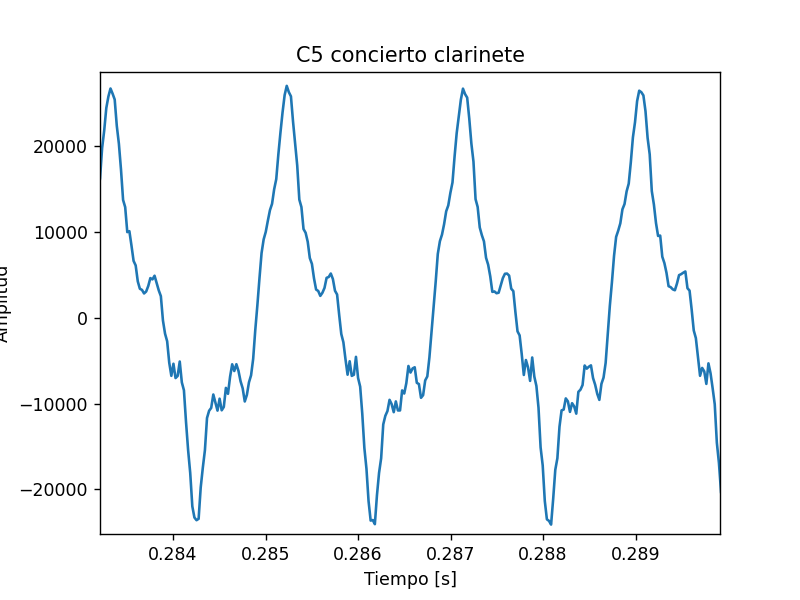

In [2]:
c5_clarinete = getSamples("C5_concierto_clarinete.wav")

# Graficamos la señal de audio
plt.figure()
plt.title("C5 concierto clarinete")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.plot(c5_clarinete[0], c5_clarinete[1])
plt.show()

Se obtienen los puntos de la FFT asociada a las muestras. Según la documentación de la librería numpy, aunque los algoritmos que implementan para la calcular la FFT son más eficientes cuando el número de muestras es potencia de 2, se pueden utilizar con un número de muestras arbitrario.

In [387]:
c5_clarinete_fft = np.fft.fft(c5_clarinete[1])

# Se comprueba que el tamaño del array de entrada a la FFT es el mismo que el de salida
c5_clarinete_fft.shape == c5_clarinete[1].shape

True

Si se imprime uno de los coeficientes de Fourier, se observa que en general serán números complejos, pero para nuestra aplicación podemos descartar la información sobre la fase.

In [388]:
print(c5_clarinete_fft[0])
magnitud_c5_clarinete_fft = np.abs(c5_clarinete_fft)
print(magnitud_c5_clarinete_fft[0])

(168265+0j)
168265.0


Visualizamos el espectro frecuencial en magnitud. Las muestras a la salida de la FFT estarán separadas en frecuencia por $1/T_s$, siendo $T_s$ el periodo de muestreo.

<IPython.core.display.Javascript object>


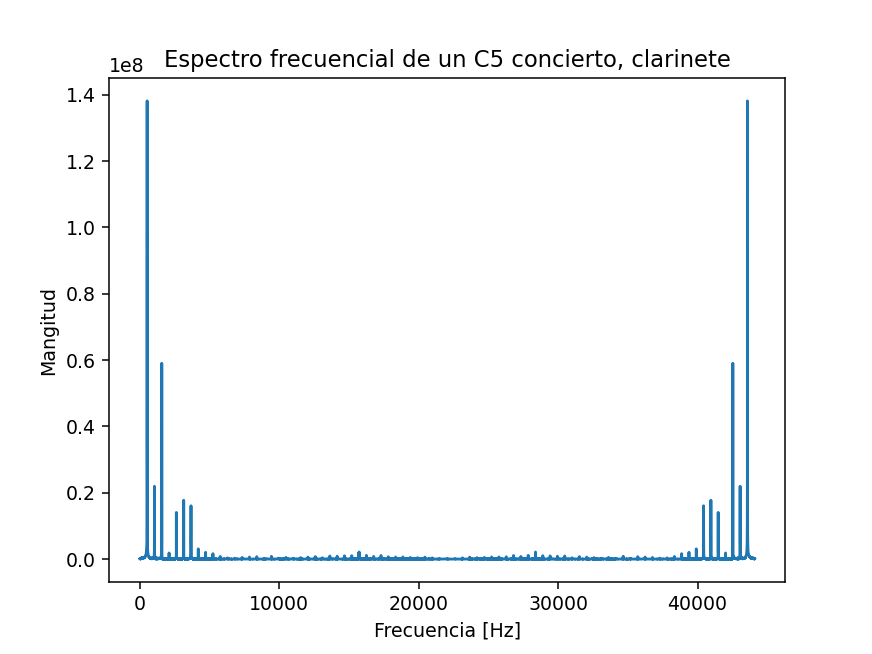

In [389]:
# Se obtiene el eje de frecuencias
Ts = 1/44100 # Siendo la frecuencia de muestreo 44.1 kHz
c5_clarinet_frec = np.linspace(0,1/Ts,len(magnitud_c5_clarinete_fft))

# Se grafica la magnitud del espectro frecuencial
plt.figure()
plt.tight_layout()
plt.title("Espectro frecuencial de un C5 concierto, clarinete")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Mangitud")
plt.plot(c5_clarinet_frec,magnitud_c5_clarinete_fft)
plt.show()

Como resultado de aplicar el algoritmo FFT obtenemos en la primera mitad del array de coeficientes de Fourier la respuesta en frecuencia para las frecuencias positivas y en la segunda parte, para las negativas. Como nuestra señal de audio es real, su espectro en frecuencia será simétrico, por lo que únicamente necesitamos la parte positiva de la respuesta en frecuencia. Hay una función específica de numpy (np.fft.rfft) que nos devuelve únicamente la parte positiva del espectro de frecuencia, y se puede utilziar cuando todas las muestras sean reales. La utilizaremos en la implementación de la aplicación.

<IPython.core.display.Javascript object>


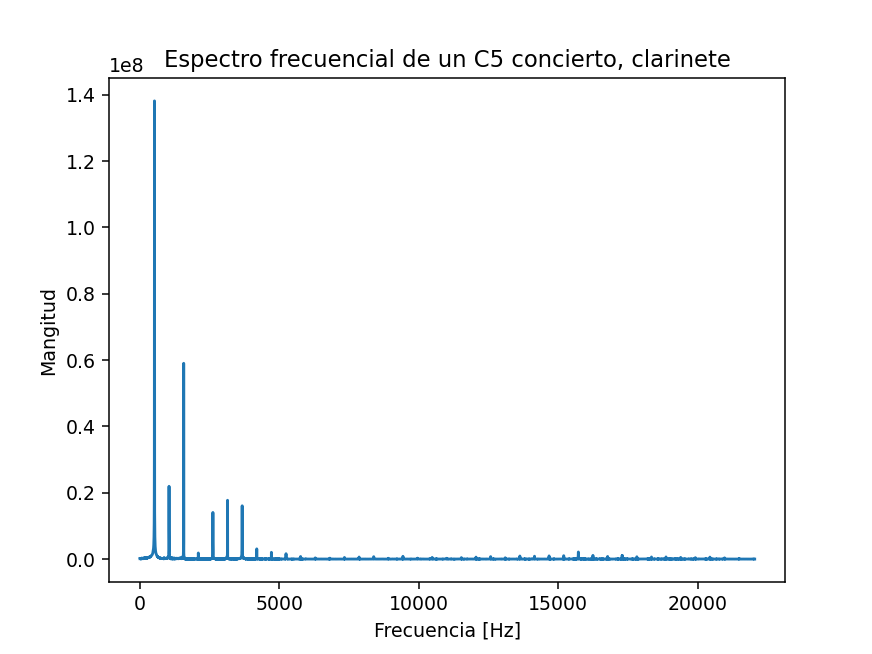

In [390]:
# Se obtiene el eje de frecuencias
Ts = 1/44100 # Siendo la frecuencia de muestreo 44.1 kHz
magnitud_c5_clarinete_fft = magnitud_c5_clarinete_fft[:int(np.round(len(magnitud_c5_clarinete_fft)/2))]
c5_clarinet_freq = np.linspace(0,1/(Ts*2),len(magnitud_c5_clarinete_fft))

# Se grafica la magnitud del espectro frecuencial
plt.figure()
plt.tight_layout()
plt.title("Espectro frecuencial de un C5 concierto, clarinete")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Mangitud")
plt.plot(c5_clarinet_freq,magnitud_c5_clarinete_fft)
plt.show()

Para la representación anterior se ha utilizado una ventana rectangular, pero más adelante se probarán distintas ventanas. Las diferencias entre las representaciones frecuenciales obtenidas para cada instrumento es una de las razones por las que el timbre es distinto aunque la nota sea la misma.

Se puede observar en este caso que la frecuencia fundamental tiene más energía que los armónicos, pero esto no es necesariamente así. Existen casos donde los armónicos tienen mayor energía, y por ello no podemos identificar la nota viendo la componente frecuencial predominante. En su lugar, se determinarán los picos frecuenciales que superen un cierto umbral y se escogerá el pico de frecuencia más baja, que será la frecuencia fundamental.

Creamos una función para obtener la menor frecuencia que tenga un máximo local y que sea como mínimo un cierto porcentaje más pequeño que el máximo global. Este porcentaje se pasa como parámetro en tanto por uno.

In [391]:
def identify_freq(magnitude_fft,Ts,threshold):
    """
    identify_frec identifica la frecuencia de la nota tocada.

    :param magnitude_fft: array de numpy que contiene la magnitud de la respuesta en frecuencia.
    :param Ts: frecuencia de muestreo.
    :param threshold: porcentaje en tanto por 1 que multiplicado por el máximo global
    dará una medida del umbral.
    :return: Devuelve la frecuencia de la nota identificada.
    """ 
    
    # Se crea el eje de frecuencias
    freq = np.linspace(0,1/(Ts*2),len(magnitud_c5_clarinete_fft))
    
    # Se identifica el máximo global
    max_value = np.max(magnitude_fft)
    
    # Lista para almacenar los máximos locales que superen el umbral
    max_frecs = []
    
    # Se determinan los índices de los máximos locales que superen el umbral
    for sampleIndex in range(1,len(magnitude_fft)-1):
        
        # Si una muestra es mayor que la anterior y la siguiente, es un máximo local
        if magnitude_fft[sampleIndex] > magnitude_fft[sampleIndex-1] \
           and magnitude_fft[sampleIndex] > magnitude_fft[sampleIndex+1]:
            
            # Se comprueba si el máximo supera el umbral
            if magnitude_fft[sampleIndex] > max_value*threshold:
                max_frecs.append(freq[sampleIndex])
    
    return min(max_frecs)

Se utiliza la función definiendo un umbral del 25% del máximo pico frecuencial, y se obtiene la frecuencia de la nota identificada.

In [392]:
identify_freq(magnitud_c5_clarinete_fft,Ts,0.25)

524.8992129007487

El máximo respecto al cual se calcula el umbral cuando se lleve a cabo el análisis de la pista de audio que contiene la melodía debe ser el máximo de la pista completa, no de cada subconjunto de muestras, pues es posible que haya subconjuntos correspondientes a silencios.

## Obtención de la nota tocada
El próximo paso será obtener la nota que se ha tocado a partir de la frecuencia. Hay que tener en cuenta en este punto que la relación frecuencial entre las notas de la escala temperada no es lineal. Es decir, no podemos tener una lista de frecuencias de notas y aproximar nuestra frecuencia a la más cercana, sino que hay que tener en cuenta que la relación entre los semitonos en la escala es de $\sqrt[12]{2}$ (es decir, para conseguir el semitono inmediatamente superior de la nota con frecuencia $f_0$, hay que multiplicar $f_0$ por $\sqrt[12]{2}$). Se nombrarán las notas en relación a un piano de 88 teclas. La nota que se ha tocado con clarinete era un C5 concierto, lo que significa que es un do en la quinta octava de un piano de 88 teclas. Las frecuencias de las notas en relación al piano de 88 teclas son:

<img src=https://lh6.googleusercontent.com/proxy/0QsbjhFtZpTqUHfHje9bUitvktbR6J-vTUDxAJTu63n5wBDKHXR8pQ26R7nClcaTT0KGKqwA6Ql0k-XMXvzeVx_Zwq4xlYyJljdKgkOeDjXKyMlbk6xNmYk5NVlRyA30zdYp9VSeTRF3>

Se puede obtener una ecuación genérica para tener el índice de la tecla pulsada a partir de la frecuencia de nota, utilizando la relación frecuencial entre semitonos, para un piano de 88 notas con la nota 49 afinada a 440 Hz:

$f(n)=(\sqrt[12]{2})^{n-49}\cdot 440Hz$

Si ahora se despeja n en la ecuación anterior, se obtiene la siguiente expresión:

$n=12\log_2\left(\frac{f}{440Hz}\right)+49$

Como la frecuencia identificada en el espectro no es exactamente una frecuencia de nota, debemos obtener el índice n, que en general no será un número entero, y después sí que podemos redondear. Se implementa esta última ecuación en una función que identifica la nota y la octava a partir de la frecuencia, además de llevar a cabo este redondeo.

In [393]:
def freq_to_note(freq):
    notes = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']

    note_index = 12*np.log2(freq/440)+49  
    note_index = round(note_index)
    
    note = (note_index - 1) % len(notes)
    note = notes[int(note)]
    
    # Como a la octava más baja se le asocian los índices de tecla -8, -7, ...
    # se le suma 8 para calcular la octava.
    octave = (note_index+8)//len(notes)
    
    return str(note)+str(int(octave))

Se identifica la nota asociada a la frecuencia fundamental del clarinete, y efectivameente se observa que es un C5:

In [394]:
print(freq_to_note(identify_freq(magnitud_c5_clarinete_fft,Ts,0.25)))

C5


## Transcripción de una melodía a partir del .wav
Una vez podemos detectar una nota individual, se procede a analizar un audio completo. Este audio estará grabado en mono y a la frecuencia estándar de 44100 Hz. Como entrada al algoritmo de transcripción se debe especificar el tempo en el que se ha tocado la melodía. Se usará una pista de prueba a 60 bpm, donde tendremos notas graves y agudas, así como diferentes figuras rítmicas.

Como se explicó anteriormente, lo primero será encontrar el número de muestras correspondientes a la mínima figura rítmica (una corchea). En un pulso tenemos 2 corcheas, por lo que en 60 bpm es equivalente a 120 corcheas/minuto.

$\frac{1}{120}\frac{\text{min}}{\text{corchea}}\cdot\frac{\text{60 seg}}{\text{1 min}}\cdot\frac{muestra}{(1/44100)\text{ seg}}$

In [395]:
fs = 44100 # Hz
bpm = 60 # Beats per minute
muestras_corchea = (1/(2*bpm))*60*fs # Muestras/corchea
print("Muestras por corchea:",int(muestras_corchea))

Muestras por corchea: 22050


Se debe dividir el array que contiene todas la muestras del audio en subconjuntos de 22050 muestras. El último subconjunto puede ser de tamaño menor que 22050.

<IPython.core.display.Javascript object>


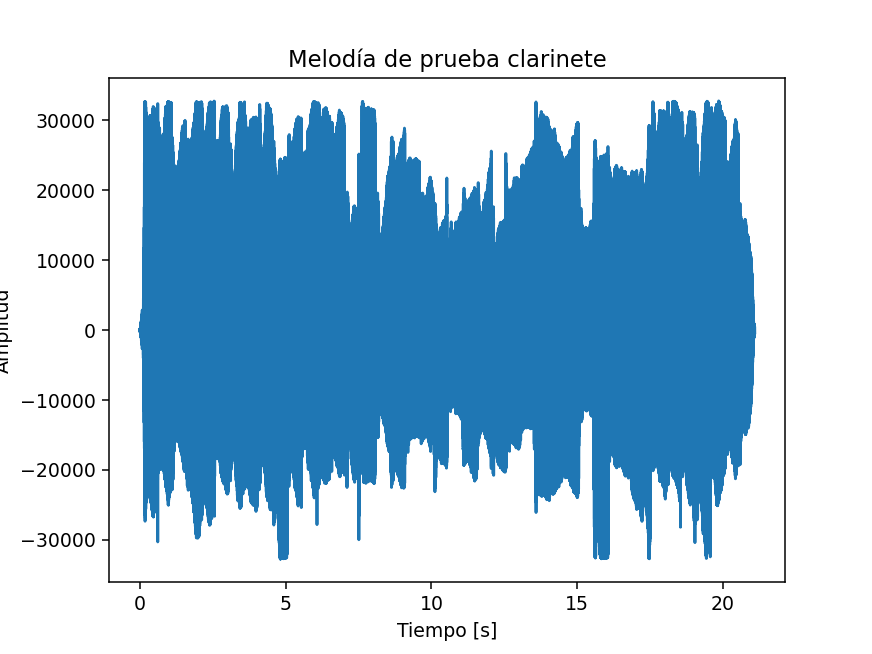

In [401]:
melodia_prueba_clarinete = getSamples("clarinete_prueba_1.wav")

# Graficamos la señal de audio
plt.figure()
plt.title("Melodía de prueba clarinete")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.plot(melodia_prueba_clarinete[0], melodia_prueba_clarinete[1])
plt.show()

In [402]:
corcheas = []
corcheas_time = []

while len(melodia_prueba_clarinete[1]) > muestras_corchea:
    corcheas.append(melodia_prueba_clarinete[1][:int(muestras_corchea)])
    corcheas_time.append(melodia_prueba_clarinete[0][:int(muestras_corchea)])
    melodia_prueba_clarinete[1] = melodia_prueba_clarinete[1][int(muestras_corchea):]
    melodia_prueba_clarinete[0] = melodia_prueba_clarinete[0][int(muestras_corchea):]
    
# Si aún quedan muestras en el audio, se añaden como un último elmento al final
if len(melodia_prueba_clarinete[1]):
    corcheas.append(melodia_prueba_clarinete[1])
    corcheas_time.append(melodia_prueba_clarinete[0])

S

<IPython.core.display.Javascript object>


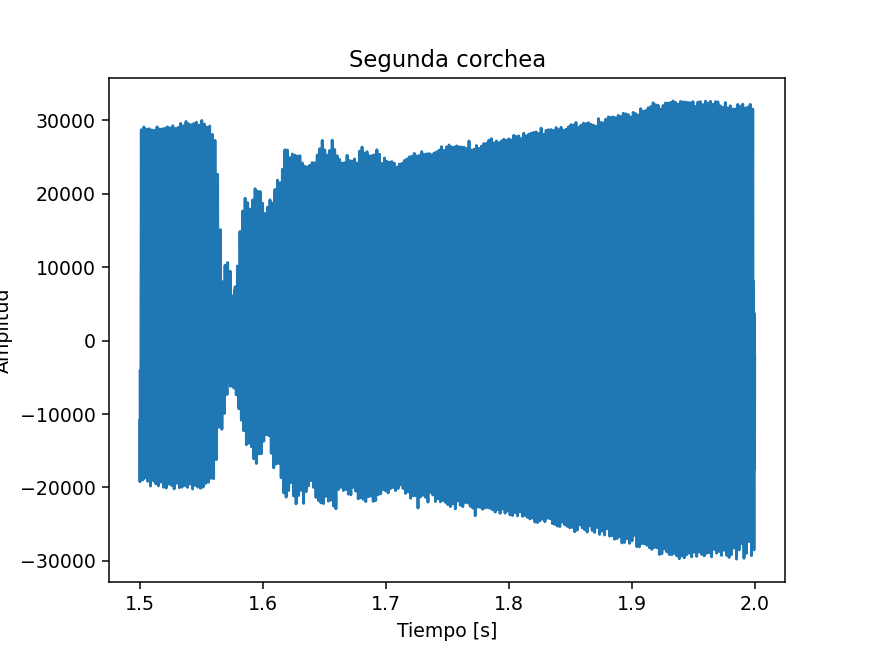

In [403]:
# Graficamos la señal de audio
plt.figure()
plt.title("Segunda corchea")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.plot(corcheas_time[3], corcheas[3])
plt.show()

In [405]:
notasIdentificadas = []

for corchea in corcheas:
    corchea_fft = np.fft.fft(corchea[1000:])
    magnitud_corchea_fft = np.abs(corchea_fft)

    # Se obtiene el eje de frecuencias
    Ts = 1/44100 # Siendo la frecuencia de muestreo 44.1 kHz
    magnitud_corchea_fft = magnitud_corchea_fft[:int(np.round(len(magnitud_corchea_fft)/2))]
    corchea_freq = np.linspace(0,1/(Ts*2),len(magnitud_corchea_fft))

    notasIdentificadas.append(freq_to_note(identify_freq(magnitud_corchea_fft,Ts,0.75)))

In [406]:
notasIdentificadas

['A#4',
 'A4',
 'A#4',
 'B4',
 'C5',
 'A4',
 'C5',
 'D#5',
 'D5',
 'F6',
 'D5',
 'A#4',
 'A4',
 'C5',
 'G#4',
 'A4',
 'F4',
 'D4',
 'A#3',
 'A3',
 'G5',
 'F3',
 'G3',
 'A3',
 'G5',
 'A3',
 'A#3',
 'D4',
 'D4',
 'D4',
 'D#4',
 'G4',
 'F4',
 'F4',
 'F4',
 'A4',
 'C5',
 'D#5',
 'C5',
 'D5',
 'A#4',
 'F4',
 'G1']